# Métricas
Neste notebook iremos apresentar uma análise com algumas métricas com o objetivo de comparar os três modelos que foram treinados.

Os modelos foram construídos a partir de diferentes aproximações de tokenização das ementas mas foram treinados com o mesmo conjunto de dados e os mesmos hiperparâmetros. Assim, iremos usar os modelos para classificar dados de um conjunto de teste e aplicar algumas métricas nos resultados para tentar inferir qual o modelo mais adequado para classificação de acórdãos.

## Imports e Constantes
Abaixo, os recursos de imports e uso de constantes ao longo desse notebook estão sendo centralizados.

In [1]:
!pip install transformers
!pip install --upgrade pytorch-lightning

     |████████████████████████████████| 2.6 MB 13.2 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 636 kB 47.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 916 kB 10.9 MB/s 
     |████████████████████████████████| 272 kB 50.0 MB/s 
     |████████████████████████████████| 118 kB 51.5 MB/s 
     |████████████████████████████████| 829 kB 38.8 MB/s 
     |████████████████████████████████| 1.3 MB 35.9 MB/s 
     |████████████████████████████████| 142 kB 52.0 MB/s 
     |████████████████████████████████| 294 kB 52.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a15cdd1c98186ddf5cbdfee1b500858ab4f424b622d28fc19b9dc467ed03b3e3
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from enum import Enum
from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from typing import List
import pytorch_lightning as pl
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
CONSTANTS = {
    'SPREADSHEET_PATH': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Test_Dataset.csv',
    'BERT_MODEL_NAME': 'neuralmind/bert-large-portuguese-cased',
    'EPOCHS': 10,
    'BATCH_SIZE': 4,
    'NUMBER_OF_BRANCHES': 13,
    'LEARNING_RATE': 2e-5,
    'MAX_TOKEN_LENGTH': 512
}

In [3]:
# Definition of mapping from law branch name to a numeric identifier

class LawBranch(Enum):
    """Mapping to a Law Branch and an identification. The enum also stores
    the law branch name in a free text form.
    """

    Penal = (0, "Direito Penal (Direito Processual Penal)")
    Administrativo = (1, "Direito Administrativo (Licitações, Contratos Administrativos, Servidores, Desapropriação, Tribunal de Contas, Improbidade, etc.)")
    Tributario = (2, "Direito Tributário/Direito Financeiro")
    Civil = (3, "Direito Civil (Direito Comercial/Direito de Família)")
    Previdenciario = (4, "Direito Previdenciário")
    Trabalho = (5, "Direito do Trabalho")
    Processual_Civil = (6, "Direito Processual Civil")
    Eleitoral = (7, "Direito Eleitoral")
    Consumidor = (8, "Direito do Consumidor")
    Internacional = (9, "Direito Internacional (Público ou Privado)")
    Militar = (10, "Direito Militar")
    Economico = (11, "Direito Econômico (Direito concorrencial e Agências Reguladoras Setoriais, Intervenção no Domínio Econômico)")
    Ambiental = (12, "Direito Ambiental")

    def get_identifier(self) -> int:
        """Retrieves the identifier number for this instance of LawBranch.

        Returns:
            int: identifier of this instance of LawBranch
        """
        return self.value[0]
    
    @staticmethod
    def get_all_names() -> List[str]:
      """Retrieves a list of all names defined in LawBranch enum.

        Returns:
          List[str]: the list of names.

      """
      names = []
      for law_branch in LawBranch:
        names.append(law_branch.name)
      return names

## Carregamento dos Dados
Para carregar os dados, é preciso se conectar à pasta compartilhada no Google Drive. Vamos utilizar os recursos que o Google Colab oferece para acessar o arquivo .csv com o conjunto de teste.

In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
test_documents = pd.read_csv(CONSTANTS['SPREADSHEET_PATH'])
test_documents.dropna(inplace=True, subset=['cod_acordao'])
test_documents.head()

,Unnamed: 0,cod_acordao,ramo,tipo_acordao,cabecalho,ementa,decisao,indexacao,somente_ementa,indicacao_exclusiva_ementa_voto,expressoes_chave
0,850,HC 141487,0,HC,HC 141487 / MG - MINAS GERAIS HABEAS CORPUS Re...,EMENTA HABEAS CORPUS. PENAL. TRÁFICO DE DROGAS...,"A Turma, por maioria, denegou a ordem, nos ter...","['VOTO VENCIDO', 'MIN', 'MARCO AURÉLIO: CONFIS...",Sim,Sim,habeas corpus
1,1942,MS 22938,1,MS,MS 22938 / PA - PARÁ MANDADO DE SEGURANÇA Rela...,EMENTA: Mandado de Segurança. Pensão temporári...,"Apresentado o feito em mesa, o julgamento foi ...","['REJEIÇÃO', 'PRELIMINAR', 'DECADÊNCIA', 'IMPE...",Sim,Sim,pensão temporária
2,5339,INQ 1978,0,INQ,Inq 1978 / PR - PARANÁ INQUÉRITO Relator(a):&n...,E M E N T A: SUPOSTA PRÁTICA DO DELITO DE CORR...,"O Tribunal, à unanimidade, rejeitou a denúncia...",['VIDE EMENTA'],Sim,Sim,ação penal
3,4982,RHC 107759,0,RHC,RHC 107759 / RJ - RIO DE JANEIRO RECURSO ORDIN...,Ementa: PENAL. PROCESSUAL PENAL. HABEAS CORPUS...,"Por maioria de votos, a Turma deu parcial prov...","['VIDE EMENTA', 'VOTO VENCIDO', 'MIN', 'MARCO ...",Sim,Sim,penal
4,4315,RE 260404,10,RE,RE 260404 / MG - MINAS GERAIS RECURSO EXTRAORD...,EMENTA: Recurso extraordinário. Alegação de in...,A Turma decidiu remeter o presente recurso ext...,"['CONSTITUCIONALIDADE', 'DISPOSITIVO', 'CÓDIGO...",Sim,Não,crimes militares


## Verificar disponibilidade da GPU
Depois verificamos se a GPU oferecida pela Google gratuitamente como ambiente de execução do notebook está disponível e funcionando corretamente. Para avaliar os modelos neste notebook, o uso da GPU não é necessário mas é recomendado pois ela oferece uma performance computacional maior em relação à CPU, diminuindo o tempo de execução do notebook substancialmente.

In [7]:
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## Modelo
Agora, definimos a classe dos modelos, o tokenizador do BERTimbau que será utilizado nas ementas e funções auxiliares para tokenizar e obter as predições dos modelos.

In [8]:
class LawDocumentClassifier(pl.LightningModule):
    
    def __init__(self, number_classes: int, steps_per_epoch: int=None, epochs: int=None, learning_rate: float=2e-5):
        super().__init__()
        
        self.model = BertForSequenceClassification.from_pretrained(
            "neuralmind/bert-large-portuguese-cased",
            num_labels=number_classes,                      # The number of output labels--2 for binary classification
            output_attentions=False,                        # Returns attention weights
            output_hidden_states=False                      # Returns all hidden states
            )
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.learning_rate = learning_rate
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            return_dict=True)
        
        return output.loss, output.logits

In [9]:
tokenizer = BertTokenizer.from_pretrained(CONSTANTS['BERT_MODEL_NAME'])

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [10]:
# Função para tokenizar as ementas
def tokenize(ementas):
  """
    @param    ementas (list): Array de ementas a serem tokenizadas.
    @return   dataloader (torch.utils.data.DataLoader): DataLoader com os dados das predições
  """
  input_ids = []
  attention_masks = []

  for ementa in ementas:
    encoded_dict = tokenizer.encode_plus(
        ementa,
        add_special_tokens = True,
        max_length = CONSTANTS['MAX_TOKEN_LENGTH'],
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        return_token_type_ids=False,
    )
        
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  prediction_data = TensorDataset(input_ids, attention_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  return DataLoader(prediction_data, sampler=prediction_sampler, batch_size=CONSTANTS['BATCH_SIZE'])


# Função que chama o modelo para classificar os acórdãos
def classify(acordaos, model):
  """
    @param  acordaos (pd.DataFrame): Dataframe com os acórdãos a serem classificados.
    @param  model (transformers.BertModel): Modelo BERT pré-treinado a ser utilizado.
    @return classifications (dict): Dicionário com os acórdãos classificados e suas ementas.
  """
  classifications = {
      'True Label': [],
      'Predicted Label': [],
      'Ementa': []
  }

  for id, row in acordaos.iterrows():
    classifications['Ementa'].append(row['ementa'])
    classifications['True Label'].append(row['ramo'])
  prediction_dataloader = tokenize(classifications['Ementa'])
  
  model.eval()
  predictions = []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        _, outputs_logits = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs_logits
    logits = logits.detach().cpu().numpy()    
    predictions.append(logits)

  for prediction_batch in predictions:
    predicted_labels = np.argmax(prediction_batch, axis=1).flatten()
    for prediction in predicted_labels:
        classifications['Predicted Label'].append(prediction)

  return classifications

Assim podemos inicializar os três diferentes modelos, carregá-los dos arquivos .bin no Google Drive e utilizá-los para classificar os acórdãos do conjunto de teste.

In [11]:
truncated_model = LawDocumentClassifier(CONSTANTS['NUMBER_OF_BRANCHES'], 3866 // CONSTANTS['BATCH_SIZE'], CONSTANTS['EPOCHS'], CONSTANTS['LEARNING_RATE'])
word_batches_model = LawDocumentClassifier(CONSTANTS['NUMBER_OF_BRANCHES'], 5599 // CONSTANTS['BATCH_SIZE'], CONSTANTS['EPOCHS'], CONSTANTS['LEARNING_RATE'])
front_back_model = LawDocumentClassifier(CONSTANTS['NUMBER_OF_BRANCHES'], 3866 // CONSTANTS['BATCH_SIZE'], CONSTANTS['EPOCHS'], CONSTANTS['LEARNING_RATE'])

truncated_model.load_state_dict(torch.load('/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/truncated_model.bin'))
word_batches_model.load_state_dict(torch.load('/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/word_batches_model.bin'))
front_back_model.load_state_dict(torch.load('/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/front_back_model.bin'))

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

<All keys matched successfully>

In [12]:
truncated_model.cuda()
truncated_classifications = classify(test_documents, truncated_model)
word_batches_model.cuda()
word_batches_classifications = classify(test_documents, word_batches_model)
front_back_model.cuda()
front_back_classifications = classify(test_documents, front_back_model)

Tendo os resultados das classificações dos três modelos, chamamos o método *classification_report* do sklearn para obter alguns cálculos gerais de métricas como precisão e acurácia.

In [13]:
print(classification_report(truncated_classifications['True Label'], truncated_classifications['Predicted Label'], target_names=LawBranch.get_all_names()))

                  precision    recall  f1-score   support

           Penal       0.98      0.97      0.98       334
  Administrativo       0.84      0.96      0.89       259
      Tributario       0.82      0.78      0.80        46
           Civil       1.00      0.08      0.15        12
  Previdenciario       0.83      0.91      0.87        32
        Trabalho       0.92      0.73      0.81        15
Processual_Civil       0.71      0.52      0.60        48
       Eleitoral       1.00      0.80      0.89         5
      Consumidor       0.00      0.00      0.00         4
   Internacional       0.90      0.98      0.94        53
         Militar       0.92      0.85      0.88        13
       Economico       0.00      0.00      0.00         3
       Ambiental       0.00      0.00      0.00         5

        accuracy                           0.90       829
       macro avg       0.69      0.58      0.60       829
    weighted avg       0.88      0.90      0.88       829



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
print(classification_report(word_batches_classifications['True Label'], word_batches_classifications['Predicted Label'], target_names=LawBranch.get_all_names()))

                  precision    recall  f1-score   support

           Penal       0.94      0.97      0.96       334
  Administrativo       0.91      0.89      0.90       259
      Tributario       0.73      0.83      0.78        46
           Civil       0.33      0.17      0.22        12
  Previdenciario       0.64      0.94      0.76        32
        Trabalho       0.92      0.73      0.81        15
Processual_Civil       0.61      0.56      0.59        48
       Eleitoral       0.57      0.80      0.67         5
      Consumidor       1.00      0.25      0.40         4
   Internacional       0.89      0.77      0.83        53
         Militar       0.90      0.69      0.78        13
       Economico       0.00      0.00      0.00         3
       Ambiental       0.83      1.00      0.91         5

        accuracy                           0.87       829
       macro avg       0.71      0.66      0.66       829
    weighted avg       0.87      0.87      0.87       829



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print(classification_report(front_back_classifications['True Label'], front_back_classifications['Predicted Label'], target_names=LawBranch.get_all_names()))

                  precision    recall  f1-score   support

           Penal       0.97      0.96      0.97       334
  Administrativo       0.83      0.93      0.88       259
      Tributario       0.86      0.83      0.84        46
           Civil       0.67      0.17      0.27        12
  Previdenciario       0.64      0.91      0.75        32
        Trabalho       0.90      0.60      0.72        15
Processual_Civil       0.79      0.46      0.58        48
       Eleitoral       0.80      0.80      0.80         5
      Consumidor       1.00      0.75      0.86         4
   Internacional       0.94      0.91      0.92        53
         Militar       0.61      0.85      0.71        13
       Economico       0.00      0.00      0.00         3
       Ambiental       1.00      0.20      0.33         5

        accuracy                           0.88       829
       macro avg       0.77      0.64      0.66       829
    weighted avg       0.88      0.88      0.87       829



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos também gerar alguns gráficos para visualização dos resultados:

### Gráficos de Barras

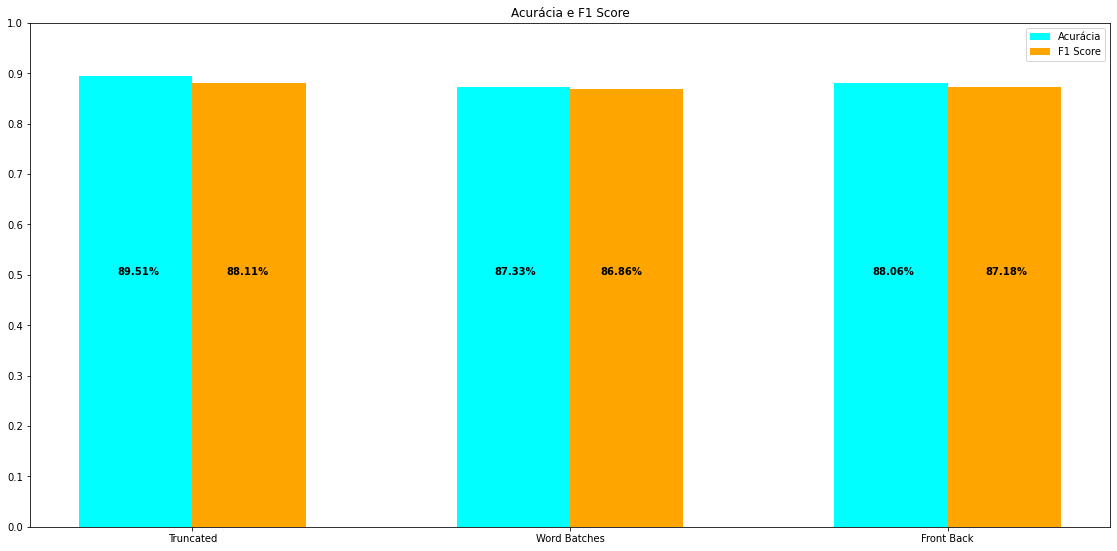

In [16]:
# Acurácia e precisão ponderada
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0,0,1,1])
models = ['Truncated', 'Word Batches', 'Front Back']
accuracies = [accuracy_score(truncated_classifications['True Label'], truncated_classifications['Predicted Label']),
              accuracy_score(word_batches_classifications['True Label'], word_batches_classifications['Predicted Label']),
              accuracy_score(front_back_classifications['True Label'], front_back_classifications['Predicted Label'])]
f1s = [f1_score(truncated_classifications['True Label'], truncated_classifications['Predicted Label'], average='weighted'),
       f1_score(word_batches_classifications['True Label'], word_batches_classifications['Predicted Label'], average='weighted'),
       f1_score(front_back_classifications['True Label'], front_back_classifications['Predicted Label'], average='weighted')]
X = np.arange(3)
ax.bar(X, accuracies, width=0.3, color='cyan')
ax.bar(X + 0.3, f1s, width=0.3, color='orange')
ax.set_title('Acurácia e F1 Score')
ax.set_ylim(top=1)
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xticks([.15, 1.15, 2.15])
ax.set_xticklabels(models)
ax.legend(['Acurácia', 'F1 Score'])
plt.text(-.05, 0.5, "{:.2%}".format(accuracies[0]), fontweight='bold')
plt.text(.24, 0.5, "{:.2%}".format(f1s[0]), fontweight='bold')
plt.text(.95, 0.5, "{:.2%}".format(accuracies[1]), fontweight='bold')
plt.text(1.23, 0.5, "{:.2%}".format(f1s[1]), fontweight='bold')
plt.text(1.95, 0.5, "{:.2%}".format(accuracies[2]), fontweight='bold')
plt.text(2.25, 0.5, "{:.2%}".format(f1s[2]), fontweight='bold')
plt.show()

In [17]:
# Funções auxiliares para obter precisão e recall por classe

def get_precision(true_labels, pred_labels, class_index):
  tp = 0
  fp = 0
  for i, label in enumerate(true_labels):
    if label == class_index:
      if label == pred_labels[i]:
        tp = tp + 1
    elif pred_labels[i] == class_index:
      fp = fp + 1
  if tp + fp == 0:
    return 0
  return tp/(tp+fp)

def get_recall(true_labels, pred_labels, class_index):
  tp = 0
  fn = 0
  for i, label in enumerate(true_labels):
    if label == class_index:
      if label == pred_labels[i]:
        tp = tp + 1
      else:
        fn = fn + 1
  return tp/(tp+fn)

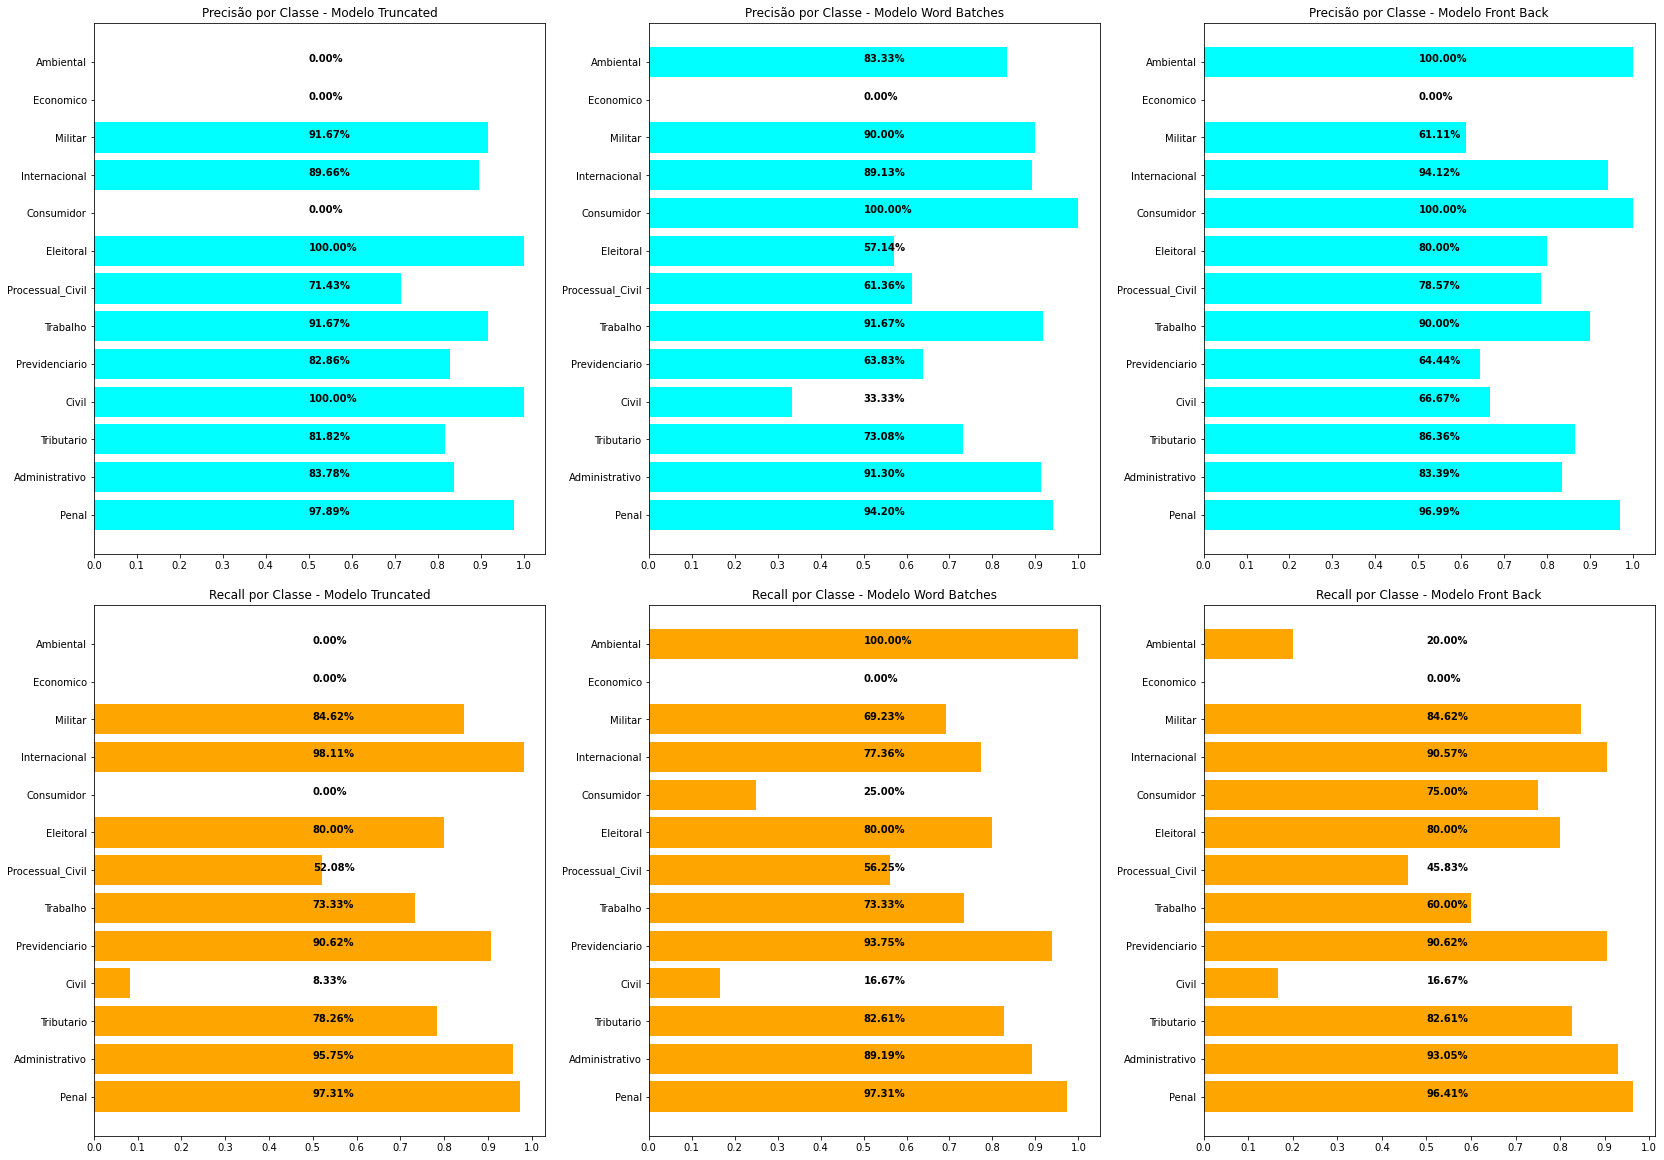

In [18]:
# Precisão e Recall por classe para todos os modelos

truncated_precisions = []
truncated_recalls = []
word_batches_precisions = []
word_batches_recalls = []
front_back_precisions = []
front_back_recalls = []

for i in range(CONSTANTS['NUMBER_OF_BRANCHES']):
  truncated_precisions.append(get_precision(truncated_classifications['True Label'], truncated_classifications['Predicted Label'], i))
  truncated_recalls.append(get_recall(truncated_classifications['True Label'], truncated_classifications['Predicted Label'], i))
  word_batches_precisions.append(get_precision(word_batches_classifications['True Label'], word_batches_classifications['Predicted Label'], i))
  word_batches_recalls.append(get_recall(word_batches_classifications['True Label'], word_batches_classifications['Predicted Label'], i))
  front_back_precisions.append(get_precision(front_back_classifications['True Label'], front_back_classifications['Predicted Label'], i))
  front_back_recalls.append(get_recall(front_back_classifications['True Label'], front_back_classifications['Predicted Label'], i))

fig, axs = plt.subplots(2, 3, figsize=(23,16), constrained_layout=True)
Y = np.arange(CONSTANTS['NUMBER_OF_BRANCHES'])

axs[0, 0].barh(Y, truncated_precisions, color='cyan')
axs[0, 0].set_yticks(Y)
axs[0, 0].set_yticklabels(LawBranch.get_all_names())
axs[0, 0].set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
axs[0, 0].set_title('Precisão por Classe - Modelo Truncated')
for i in Y:
  axs[0, 0].text(.5, i, "{:.2%}".format(truncated_precisions[i]), fontweight='bold')

axs[1, 0].barh(Y, truncated_recalls, color='orange')
axs[1, 0].set_yticks(Y)
axs[1, 0].set_yticklabels(LawBranch.get_all_names())
axs[1, 0].set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
axs[1, 0].set_title('Recall por Classe - Modelo Truncated')
for i in Y:
  axs[1, 0].text(.5, i, "{:.2%}".format(truncated_recalls[i]), fontweight='bold')

axs[0, 1].barh(Y, word_batches_precisions, color='cyan')
axs[0, 1].set_yticks(Y)
axs[0, 1].set_yticklabels(LawBranch.get_all_names())
axs[0, 1].set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
axs[0, 1].set_title('Precisão por Classe - Modelo Word Batches')
for i in Y:
  axs[0, 1].text(.5, i, "{:.2%}".format(word_batches_precisions[i]), fontweight='bold')

axs[1, 1].barh(Y, word_batches_recalls, color='orange')
axs[1, 1].set_yticks(Y)
axs[1, 1].set_yticklabels(LawBranch.get_all_names())
axs[1, 1].set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
axs[1, 1].set_title('Recall por Classe - Modelo Word Batches')
for i in Y:
  axs[1, 1].text(.5, i, "{:.2%}".format(word_batches_recalls[i]), fontweight='bold')

axs[0, 2].barh(Y, front_back_precisions, color='cyan')
axs[0, 2].set_yticks(Y)
axs[0, 2].set_yticklabels(LawBranch.get_all_names())
axs[0, 2].set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
axs[0, 2].set_title('Precisão por Classe - Modelo Front Back')
for i in Y:
  axs[0, 2].text(.5, i, "{:.2%}".format(front_back_precisions[i]), fontweight='bold')

axs[1, 2].barh(Y, front_back_recalls, color='orange')
axs[1, 2].set_yticks(Y)
axs[1, 2].set_yticklabels(LawBranch.get_all_names())
axs[1, 2].set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
axs[1, 2].set_title('Recall por Classe - Modelo Front Back')
for i in Y:
  axs[1, 2].text(.5, i, "{:.2%}".format(front_back_recalls[i]), fontweight='bold')

plt.show()

### Matriz de Confusão

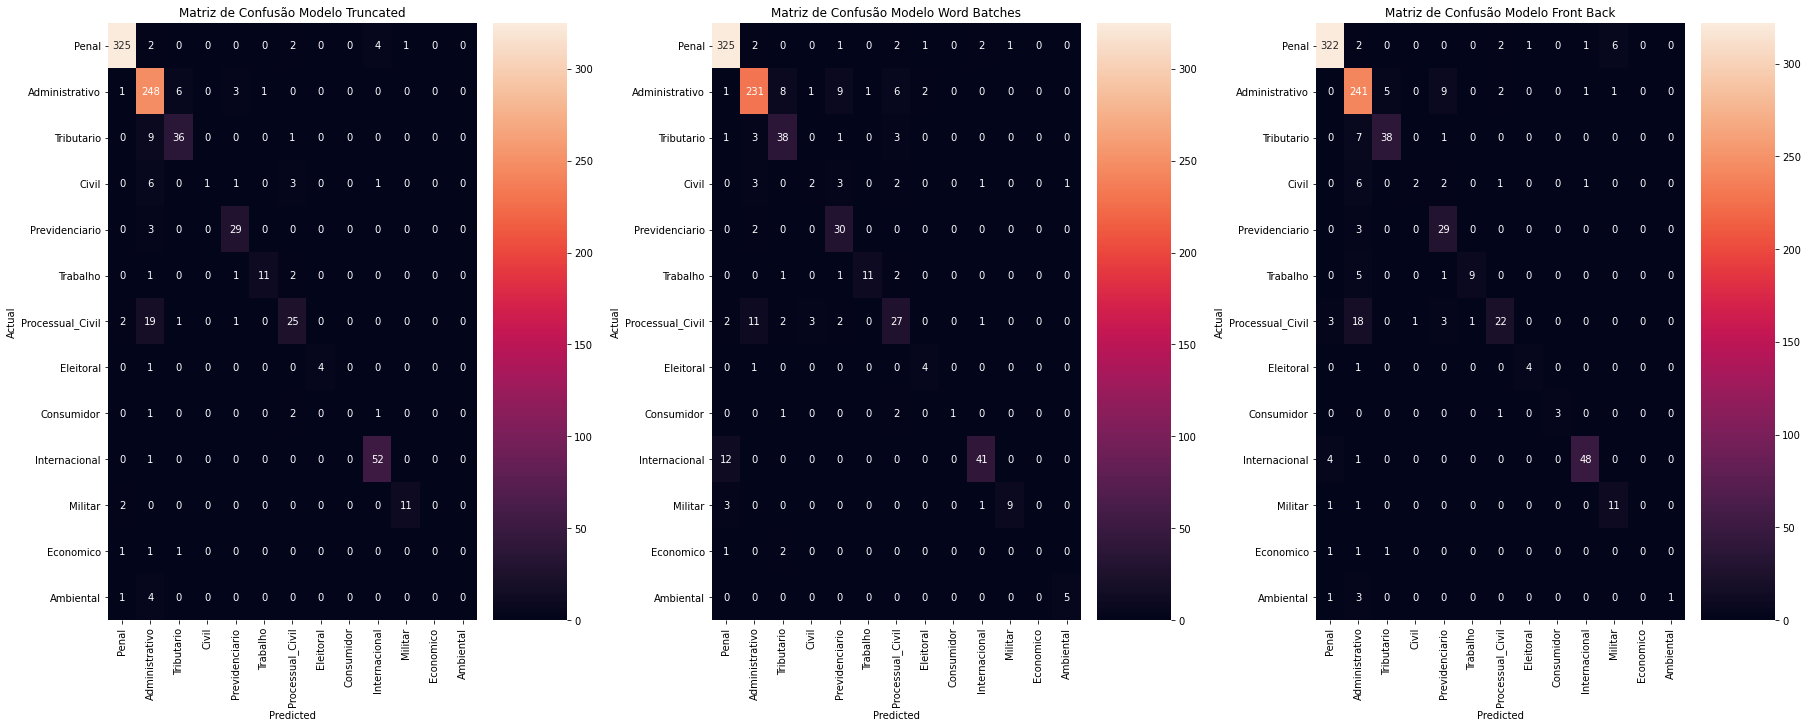

In [32]:
conf_mat_truncated = confusion_matrix(truncated_classifications['True Label'], truncated_classifications['Predicted Label'])
conf_mat_word_batches = confusion_matrix(word_batches_classifications['True Label'], word_batches_classifications['Predicted Label'])
conf_mat_front_back = confusion_matrix(front_back_classifications['True Label'], front_back_classifications['Predicted Label'])
fig, axs = plt.subplots(1, 3, figsize=(25,10), constrained_layout=True)
ticks = LawBranch.get_all_names()
sns.heatmap(conf_mat_truncated, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks, ax=axs[0])
sns.heatmap(conf_mat_word_batches, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks, ax=axs[1])
sns.heatmap(conf_mat_front_back, annot=True, fmt='d',
            xticklabels=ticks, yticklabels=ticks, ax=axs[2])
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')
axs[0].set_title('Matriz de Confusão Modelo Truncated')
axs[1].set_ylabel('Actual')
axs[1].set_xlabel('Predicted')
axs[1].set_title('Matriz de Confusão Modelo Word Batches')
axs[2].set_ylabel('Actual')
axs[2].set_xlabel('Predicted')
axs[2].set_title('Matriz de Confusão Modelo Front Back')

plt.show()

## Escolha do Modelo

Visualizando os resultados obtidos e com a ajuda dos gráficos construídos, é possível fazer uma escolha em relação a qual aproximação de modelo seria o mais adequado para ser aperfeiçoado e utilizado no classificador de acórdãos.

Os três modelos treinados com os mesmos hiperparâmetros e com o mesmo conjunto de dados de treinamento apresentaram resultados semelhantes ao serem avaliados no conjunto de dados de teste. Os valores de acurácia e F1 Score, que é uma média harmônica entre precisão e recall, ficaram bem próximos com um intervalo entre eles não maior que 3%, sendo o modelo Truncated o que obteve os maiores valores nas três métricas com aproximadamente 90% de acurácia e 88% de F1 Score, seguido do modelo Front Back, com aproximadamente 88% de acurácia e 87% de F1 Score, e por último o modelo Word Batches, com aproximadamente 87% de acurácia e 87% de F1 Score.

Já observando os gráficos de precisão e recall por classe é possível notar que 
os três modelos obtém resultados relativamente iguais, sendo muito eficientes para algumas classes e muito ruins para as outras. O modelo Truncated em específico possui um comportamento "binário", tendo apenas valores altos ou valores zerados. Esse comportamento e os resultados dos modelos para essas métricas são justificados pelo desbalanceamento do conjunto de dados de teste, que possui grande parte dos registros distribuídos em apenas 2 das 13 classes. Assim se torna mais difícil julgar e comparar a precisão e a eficiência relativa dos modelos. Esse desbalanceamento pode ser visto nas matrizes de confusão, que mostram os números de acertos, de falsos positivos e de falsos negativos e com eles é possível ver a diferença do número de dados entre todas as classes.

Um outro aspecto importante que pode ser considerado é o da composição da ementa do acórdão, que é a principal input dos modelos. Analisando os dados disponíveis, é possível perceber que em grande parte dos casos o começo do texto das ementas contém informações suficientes para a predição do ramo do direito do acórdão. Essas informações aparecem em formato de palavras chave e às vezes até apresentam diretamente o ramo pertencente do acórdão. Assim, as aproximações de construção de modelo que levem em consideração o início do texto da ementa, em teoria, devem apresentar resultados melhores.

Dadas essas observações, a aproximação de modelo escolhida para ser utilizada foi o modelo Truncated pois ele obteve um resultado um pouco melhor que os outros nas métricas gerais no conjunto de teste e além disso se encaixa nas condições de composição da ementa descritas acima, apenas cortando o final do texto, caso seja muito grande.